In [1]:
# default_exp module_embedding_exploration

In [2]:
# export

import os
import gensim
import umap
import altair
import pandas as pd


import matplotlib.pyplot as plt
from github_search import neptune_util
import neptune

In [3]:
%cd ..

/home/kuba/Projects/github_search


In [6]:
word_vectors_filename = "import2vec_module_vectors.bin"
project = neptune_util.init_neptune_project()

experiment = project.get_experiments()[0]
experiment.download_artifact(os.path.basename(word_vectors_filename), "/tmp/models")

In [7]:
project.get_experiments()

[Experiment(GIT-14),
 Experiment(GIT-17),
 Experiment(GIT-19),
 Experiment(GIT-20),
 Experiment(GIT-21),
 Experiment(GIT-22),
 Experiment(GIT-23)]

In [8]:
experiment.get_parameters()

{'n_iterations': 1000.0,
 'n_positive_imports': 32.0,
 'embedding_dim': 100.0,
 'lr': 0.001}

In [9]:
!ls data

CodeSearchNet					pwc_methods.json
import2vec_module_vectors_Adam_dim100_bs32.bin	pwc_methods.json.gz
links-between-papers-and-code.json.gz		python
module_import_corpus.csv			python_files.csv
module_import_corpus.csv.dvc			python_files.csv.dvc
nmf_module_vectors.txt				python_files.csv.gz
papers-with-abstracts.json.gz			repo_pypi_descriptions.csv
paperswithcode_scraped_tasks.csv		token.txt
paperswithcode_scraped_tasks.csv.dvc


In [10]:
import2vec = gensim.models.KeyedVectors.load(
    os.path.join("/tmp", "models", word_vectors_filename)
)

In [34]:
import2vec.most_similar("tensorflow")

[('mobilebert', 0.3040066659450531),
 ('theano', 0.28138798475265503),
 ('_roi_pooling', 0.2558634877204895),
 ('random', 0.24557331204414368),
 ('sys', 0.2418888509273529),
 ('deepclaw', 0.2400122582912445),
 ('pyaudio', 0.239332914352417),
 ('gym_sokoban_fast', 0.23615522682666779),
 ('tf3d', 0.23450404405593872),
 ('convolution', 0.22794610261917114)]

In [35]:
import2vec.most_similar("keras")

[('policy', 0.3941139280796051),
 ('post_processing', 0.3359375298023224),
 ('cache', 0.2998649477958679),
 ('task_configs', 0.29136329889297485),
 ('ohem_sampler', 0.28495854139328003),
 ('collections', 0.27990061044692993),
 ('atom', 0.2736361026763916),
 ('distracting_control', 0.2718268632888794),
 ('caffe_parser', 0.2711910307407379),
 ('qm9', 0.2700338363647461)]

In [36]:
import2vec.most_similar("sklearn")

[('slot_attention', 0.33395183086395264),
 ('device_utils', 0.3184097111225128),
 ('adaptdl', 0.2869527339935303),
 ('rllab', 0.28253668546676636),
 ('dialogentail', 0.28197041153907776),
 ('weight_drop', 0.28076624870300293),
 ('tensorflow_fold', 0.2806421220302582),
 ('fairseq_encoder', 0.28051912784576416),
 ('linear_reid_head', 0.2756787836551666),
 ('gb2312prober', 0.27408525347709656)]

In [37]:
import2vec.most_similar("torch")

[('clu', 0.3703650236129761),
 ('atlas', 0.3180058002471924),
 ('detect_face', 0.3134281635284424),
 ('trimesh', 0.29719382524490356),
 ('relaxation', 0.29150551557540894),
 ('warnings', 0.2890550196170807),
 ('data_gen', 0.2877260446548462),
 ('numpy', 0.2876211702823639),
 ('newsgac', 0.28372815251350403),
 ('python_speech_features', 0.2761905789375305)]

In [39]:
import2vec.most_similar(positive=["sklearn"], negative=["numpy"])

[('unet3d', 0.3302142918109894),
 ('tensorflow_serving', 0.32874393463134766),
 ('spotlight', 0.32856568694114685),
 ('slot_attention', 0.3215056359767914),
 ('_binary', 0.31121495366096497),
 ('linear_reid_head', 0.3049750328063965),
 ('screening', 0.3036873936653137),
 ('dna_creators', 0.3009897470474243),
 ('tensorflow_docs', 0.2957450747489929),
 ('optimizers', 0.2889431118965149)]

In [18]:
# export


default_dimensionality_reducer = umap.UMAP(n_neighbors=20, metric="cosine")


def make_vizualization_df(
    keyed_vectors, dimensionality_reducer=default_dimensionality_reducer
):
    vectors = import2vec.syn0

    umap_vectors = dimensionality_reducer.fit_transform(vectors)
    viz_df = pd.DataFrame(umap_vectors)
    viz_df.columns = ["x", "y"]
    viz_df["name"] = import2vec.vocab.keys()
    return viz_df

In [19]:
viz_df = make_vizualization_df(import2vec)

<ipython-input-18-438c7ad267d5>:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  vectors = import2vec.syn0


In [20]:
# export


reference_modules = [
    "numpy",
    "tensorflow",
    "keras",
    "sklearn",
    "scipy",
    "matplotlib",
    "torch",
    "os",
    "sys",
    "seaborn",
]

In [21]:
# export


def show_scatterplot(viz_df, reference_modules=reference_modules):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(viz_df["x"], viz_df["y"], alpha=0.2)

    for module_name in reference_modules:
        module_row = viz_df[viz_df["name"] == module_name].iloc[0]
        ax.scatter([module_row["x"]], [module_row["y"]], c="red")
        ax.annotate(module_name, (module_row["x"], module_row["y"]))

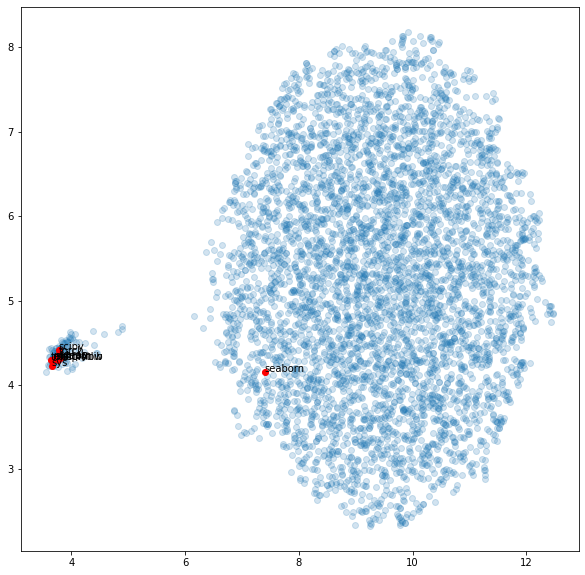

In [22]:
show_scatterplot(viz_df)

In [24]:
altair_scatterplot = (
    altair.Chart(viz_df.sample(1000))
    .mark_circle(size=100, color="red", opacity=0.1)
    .encode(x="x", y="y", tooltip=["name"])
    .interactive()
)

reference_scatterplot = (
    altair.Chart(viz_df[viz_df["name"].isin(reference_modules)])
    .mark_circle(size=100, color="blue", opacity=1.0)
    .encode(x="x", y="y", tooltip=["name"])
    .interactive()
)

altair_scatterplot + reference_scatterplot

alt.LayerChart(...)